<a href="https://colab.research.google.com/github/marcoalt/Colab/blob/main/hrv_thresholds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart rate variability (HRV) derived aerobic threshold estimation

In this workbook I have implemented a simple script to compute *alpha 1* from detrended fluctuation analysis (DFA), a method proposed in literature [1] to estimate the aerobic threshold based on HRV data. Special thanks to Raúl Celdrán, Alan Couzens and James Cobb for stimulating this conversation on Twitter. **Feel free to comment [here](https://twitter.com/altini_marco/status/1337696020394893314) for any feedback or findings linked to this notebook**.

The full text of the paper can be found [here](https://www.frontiersin.org/articles/10.3389/fphys.2020.550572/full). According to the paper, **a value of alpha close to 0.75 should correspond to the aerobic threshold, while alpha should approximate 0.5 as intensity increases** past the anaerobic threshold. 

DFA's alpha was also investigated in [2] (link [here](https://www.researchgate.net/profile/Denis_Mottet2/publication/7194410_Non-Linear_Analyses_of_Heart_Rate_Variability_During_Heavy_Exercise_and_Recovery_in_Cyclists/links/09e415048cf4cd4818000000.pdf)), showing similar results, with alpha equal to 1 at rest and at 40% of VO2max, and reducing to 0.5 at 90% VO2max.

This method seems particularly interesting as it **does not require an incremental test and could therefore be easier to implement in practice** as an additional check for exercise intensity. Since no incremental test is required, we can use this workbook with any workout file to compute *alpha 1* and see if the scores reflect our knowledge of the aerobic threshold for a given athlete and workout 

Important prerequisites:

*   **You need an accurate chest strap**. Unfortunately many chest straps are able to provide accurate heart rate data but do not provide accurate beat to beat data for HRV analysis (RR intervals). To make the matter worse, **many chest straps (all?) still provide RR intervals on top of the recorded averaged heart rate, even when they are unable to compute them accurately, making it difficult even to understand if we are collecting usable data or not**. My recommendation is to use a Polar H7 or H10, as these have both been validated in their ability to measure accurately RR intervals.
*   **You need a *.fit* file including RR intervals**. This can be done typically by linking a watch like a Garmin to a chest strap, and enabling HRV data collection (I've learnt this from Alan Couzens, see how to configure your watch, in his post [here](https://alancouzens.com/blog/get_hrv_data_from_fit_file.html))

[1] Gronwald, T., Rogers, B., & Hoos, O. (2020). Fractal correlation properties of heart rate variability: A new biomarker for intensity distribution in endurance exercise and training prescription?. Frontiers in Physiology, 11, 1152.

[2] Le Gallais, D. (2005). Non-linear analyses of heart rate variability during heavy exercise and recovery in cyclists. Int J Sports Med, 26, 1-6.

Let's start by installing a few libraries needed to process the *.fit* file as well as compute HRV features and plot the data using ggplot:



In [ ]:
%pip install pyhrv
%pip install fitparse
%pip install plotnine

import pyhrv
import fitparse
from plotnine import *

and load a few common libraries:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Loading the data



First we can mount our Google Drive, so that files remain available in the future. You most likely **need to edit these steps to load your own file**

For this example, I am loading a 90 minutes run with a slightly faster finish. The run was otherwise around my aerobic threshold

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Then we can read our data:


In [ ]:
fit_file = fitparse.FitFile('/content/gdrive/MyDrive/Colab Notebooks/Data/Thresholds/aerobic_harderfinish.fit')

# Removing artifacts and plotting the RR intervals

Now borring Alan's code, we get the RR intervals from the *.fit* file, remove artifacts and compute timestamps. Here I have also reduced the allowed beat to beat difference as I have noticed that my strap includes quite some artifacts when using the standard 20-25% threshold recommended for resting measurements. Obviously during exercise the beat to beat differences are minimal (almost zero as a matter of fact), and therefore we can be a bit more strict with our thresholds. **Always make sure to plot your data with and without artifact correction to see visually if you had any artifacts and if the procedure worked well**, otherwise none of what we will compute later will make any sense (HRV is highly affected by even minimal artifacts). Finally, we create a data frame to manipulate the data more easily later on.

Note for Suunto users: if you use a Suunto, the code below might not work as the format is slightly different. Please refer to [this edit](https://twitter.com/StefanMurnau/status/1337855406572449792/photo/1) and you should be able to get it to work.

In [ ]:
RRs = []
for record in fit_file.get_messages('hrv'):
        for record_data in record:
          for RR_interval in record_data.value:
            if RR_interval is not None:
              RRs.append(RR_interval)

artifact_correction_threshold = 0.10
filtered_RRs = []
for i in range(len(RRs)):
  if RRs[(i-1)]*(1-artifact_correction_threshold) < RRs[i] < RRs[(i-1)]*(1+artifact_correction_threshold):
        filtered_RRs.append(RRs[i])

x = []
total = 0
for i in range(len(filtered_RRs)):
  total = total+filtered_RRs[i]
  x.append(total)

df = pd.DataFrame()
df['timestamp'] = x
df['RR'] = filtered_RRs

Always plot your data, it is really easy to get this wrong just because we are using the wrong strap or leaving artifacts in the RR intervals time series:

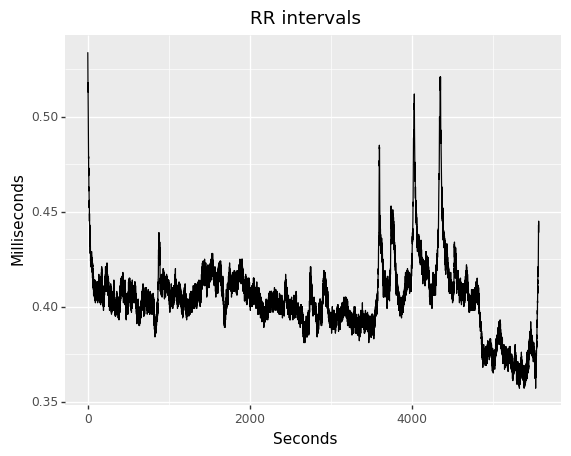

<ggplot: (-9223363244483561833)>

In [ ]:
(ggplot(df)
    + aes(x='timestamp', y='RR')
    + geom_line()
    + labs(title="RR intervals", x='Seconds', y="Milliseconds")
    )

As we can see from the plot above, RR intervals are rather stable for the first hour, in which the effort is around my aeroibic threshold. Then we have some spikes, those are simply breaks (traffic lights), which of course reduce heart rate (hence higher RR intervals, which are the inverse of instantaneous heart rate). Finally, as I push a bit harder towards the end of the workout, we have lower RR intervals

# Computing features

Alright, if the data looks good and artifact free, we can proceed and compute different HRV features. For this purpose, **we need to determine the features computation window**. The window length will have an impact as some features can only be computed with a few minutes of data (for example the low frequency power), while other features are relatively stable even with just a few seconds of data (rMSSD for example). 

Additionally, **there are trade offs between the amount of data to be used (in theory the more the better) and the issue of computing features during a relatively stable period**, in which we have a steady state (intensity and heart rate are not changing that much). 

Hence, **my recommendation would be to use either a workout with a stable / constant effort at low intensity (and maybe try a few files to see if you can find differences in alpha 1 just below or above your aerobic threshold), or to use a progression workout**, in which the intensity is relatively stable for at least 5-8 minutes at each step. This way we should get features representative of what we are trying to capture, otherwise the effect of recoveries, short intervals, etc. - will create issues for this analysis as we are not looking at instantaneous heart rate values, but we are using a few minutes of data to compute HRV features

For the computations below, I have picked 3 minutes as the window length, which should work decently for most features. You can change this parameter editing the *step* variable, which is the window length in seconds:


In [ ]:
features = []
step = 180
for index in range(0, int(round(np.max(x)/step))):
    
    array_rr = df.loc[(df['timestamp'] >= (index*step)) & (df['timestamp'] <= (index+1)*step), 'RR']*1000
    # compute heart rate
    heartrate = round(60000/np.mean(array_rr), 2)
    # compute rmssd
    NNdiff = np.abs(np.diff(array_rr))
    rmssd = round(np.sqrt(np.sum((NNdiff * NNdiff) / len(NNdiff))), 2)
    # compute sdnn 
    sdnn = round(np.std(array_rr), 2)
    #dfa, alpha 1
    alpha1 = pyhrv.nonlinear.dfa(array_rr, show = False)['dfa_alpha1']
    #frequency domain features 
    freq_peaks = pyhrv.frequency_domain.welch_psd(array_rr, show = False)['fft_peak']
    freq_abs = pyhrv.frequency_domain.welch_psd(array_rr, show = False)['fft_abs']

    curr_features = {
        'timestamp': index,
        'heartrate': heartrate,
        'rmssd': rmssd,
        'sdnn': sdnn,
        'alpha1': alpha1,
        'lf_peak':freq_peaks[1],
        'hf_peak':freq_peaks[2],
        'lf_power':freq_abs[1],
        'hf_power':freq_abs[2],
    }

    features.append(curr_features)

features_df = pd.DataFrame(features)    

We now have a new data frame with HRV features computed every 3 minutes:

In [ ]:
features_df.head()

,timestamp,heartrate,rmssd,sdnn,alpha1,lf_peak,hf_peak,lf_power,hf_power
0,0,142.52,3.75,23.78,1.014889,0.053711,0.319336,1.709741,0.830801
1,1,147.69,3.62,5.97,0.700504,0.042969,0.349609,3.081623,0.780910
2,2,147.98,3.78,5.17,0.683368,0.040039,0.342773,1.250505,1.139818
3,3,149.26,3.27,5.20,0.663937,0.068359,0.399414,0.407405,0.620779
4,4,148.88,3.64,10.96,0.749292,0.047852,0.398438,0.841165,0.674141


# Analyzing results

Let's look at *alpha 1*. According to the papers, you should see the following:


*   Values close to 1 for very low intensity efforts (40% of VO2max)
*   Values close 0.75 for the aerobic threshold
*   Values close to 0.5 for anything beyond the anaerobic threshold






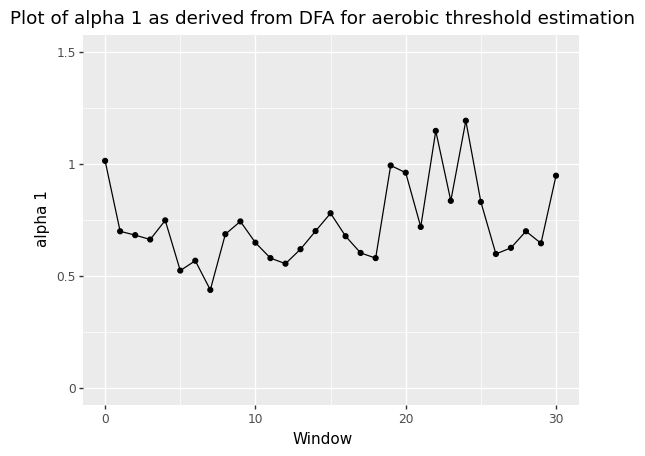

<ggplot: (8792354979781)>

In [ ]:
(ggplot(features_df)
    + aes(x='timestamp', y='alpha1')
    + geom_point()
    + geom_line()
    + scale_y_continuous(limits = [0, 1.5]) # this seems to be the range of meaningful values
    + labs(title="Plot of alpha 1 as derived from DFA for aerobic threshold estimation", x='Window', y="alpha 1")) 

Finally, assuming we have loaded a constant effort, we can also compute the average *alpha 1*:

In [ ]:
round(np.mean(features_df['alpha1']), 2)

0.73

In this example file, we have an average *alpha 1* that is exactly what it should be according to literature (0.75 for an effort close to aerobic threshold). So far so good. However, I was a bit surprised not to see a reduction in *alpha 1* as I was pushing harder towards the end of the workout. 

I have also tried slower runs and found the average *alpha 1* to be indeed a bit higher, but the question at this point remains if this piece of information is more informative than heart rate alone. I'm curious to collect more data and see the results.

# Updates
I have just discussed above how some of the data might not be relevant as we are not in a steady state (for example the change in heart rate shown when stopping at a traffic light), hence a small change we could implement is to remove those data points automatically.

For this purpose, we can use the SDNN value, as this feature captures the overall variation around the mean for a computation window, and therefore even if the beat to beat differences stay small (as shown in a small rMSSD), the overall variations from the mean of the window can be large during recoveries. Let's use a simple threshold to remove alpha 1 scores computed on non-steady state data as derived from SDNN data:

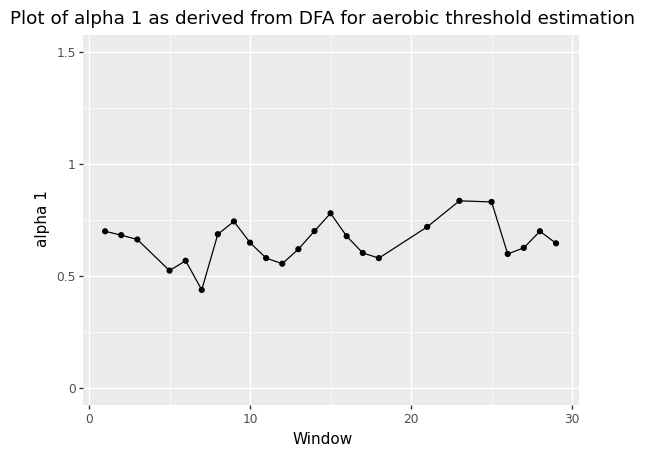

<ggplot: (-9223363244499992078)>

In [ ]:
threshold_sdnn = 10 #rather arbitrary, based on visual inspection of the data
features_df_filtered = features_df.loc[features_df['sdnn'] < threshold_sdnn, ]

(ggplot(features_df_filtered)
    + aes(x='timestamp', y='alpha1')
    + geom_point()
    + geom_line()
    + scale_y_continuous(limits = [0, 1.5])
    + labs(title="Alpha 1 as derived from DFA for aerobic threshold estimation", x='Window', y="alpha 1")) 

It seems that we were able to remove a few of the less relevant data points. Something else that we can do is to use a different color coding, since this method does not require locating inflection points or person-specific thresholds:

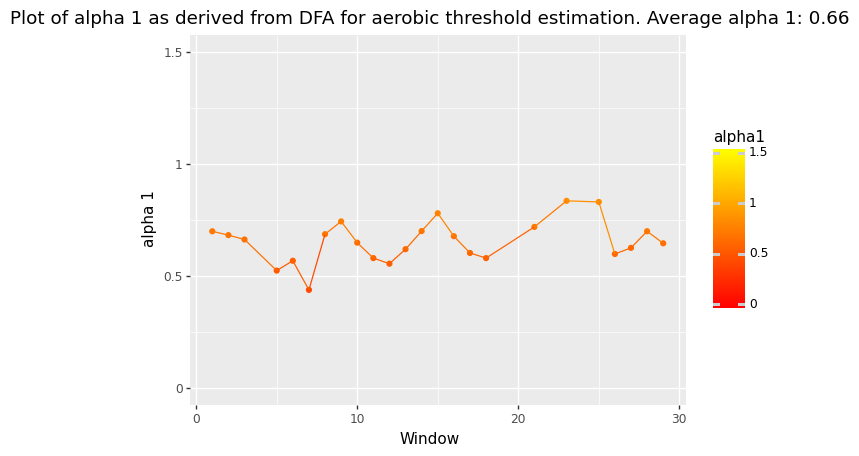

<ggplot: (8792351648758)>

In [ ]:
(ggplot(features_df_filtered)
    + aes(x='timestamp', y='alpha1', color = 'alpha1')
    + geom_point()
    + geom_line()
    + scale_y_continuous(limits = [0, 1.5])
    + scale_color_gradient(low="red",high="yellow", limits = [0, 1.5])
    + labs(title="Alpha 1 as derived from DFA for aerobic threshold estimation. Average alpha 1: " + str(round(np.mean(features_df_filtered['alpha1']), 2)), x='Window', y="alpha 1"))

In [ ]:
round(np.mean(features_df_filtered['alpha1']), 2)

0.66

Which gives a mostly orange line, as expected since we are in the middle of the range (0 - 1.5, with the aerobic threshold set to approximately 0.75). Here is what is reported in the paper linked at the beginning of this post [1], for an incremental test carried out by two people of different fitness levels (as shown by their VO2max):

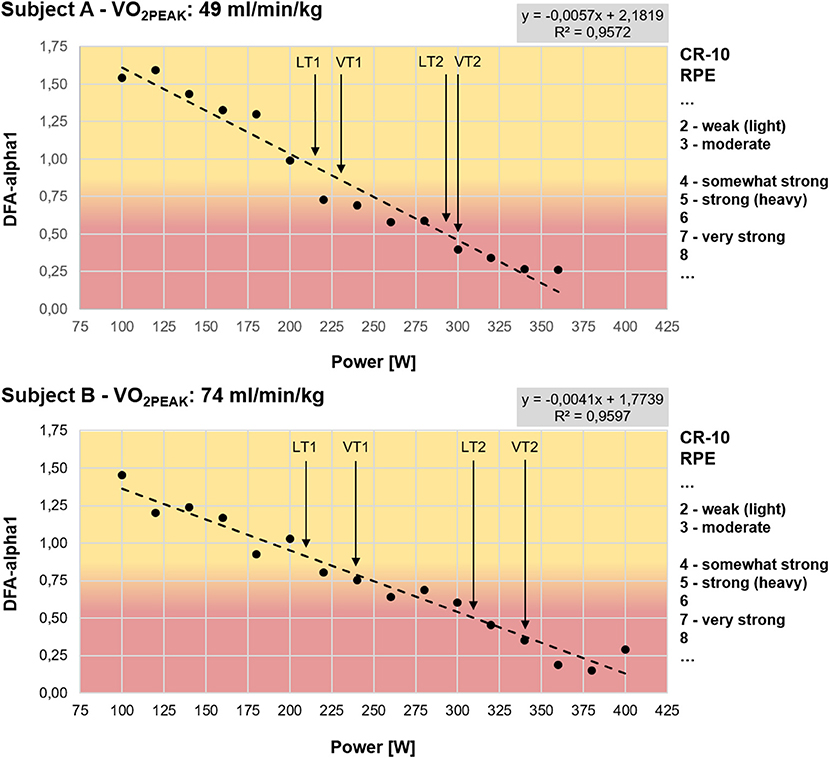

Note that in our data, we are using a rather constant effort, not an incremental test, and therefore we expect *alpha 1* to be stable

Possible extensions at this point could be the following:


1.   **Use data from an incremental test** (doesn't have to be maximal) to see if *alpha 1* tracks well with changes in intensity
2.   **Load different workouts of various intensities and plot the average external load (e.g. power or pace) against the average *alpha 1* of each workout**, to analyze the relationship between the two, which should be similar to what we see in an incremental test

